# Iceland Aerial Preprocessing

In [14]:
import hipp
import os
import matplotlib.pyplot as plt
import cv2

## Settings

In [15]:
PROJECT_DIRECTORY = "data/iceland/aerial/1980_08_22"
RAW_IMAGES = os.path.join(PROJECT_DIRECTORY, "raw_images")
PREPROCESSED_IMAGES = os.path.join(PROJECT_DIRECTORY, "preprocessed_images")

QUICKVIEW_FACTOR = 0.20

MAX_WORKERS = 6

## The Dataset

The dataset consists of **46 aerial photographs** captured using a **Wild RC10 camera** ([calibration report](data/metadata/iceland_aerial/calibration_report.pdf)). The images were acquired on **August 22, 1980**, and cover the **South Iceland**.

They are available for download via the ftp of Joaquin.


In [16]:
!wget -c -r -np -nd -A "*.tif" -P {RAW_IMAGES} https://ftp.lmi.is/.stm/joaquin/history/iceland/aerial_images/19800822/raw_images/


--2025-06-20 15:20:01--  https://ftp.lmi.is/.stm/joaquin/history/iceland/aerial_images/19800822/raw_images/
Resolving ftp.lmi.is (ftp.lmi.is)... 178.19.53.124
Connecting to ftp.lmi.is (ftp.lmi.is)|178.19.53.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘data/iceland/aerial/1980_08_22/raw_images/index.html.tmp’

index.html.tmp          [ <=>                ]  12.93K  --.-KB/s    in 0s      

2025-06-20 15:20:01 (1.25 GB/s) - ‘data/iceland/aerial/1980_08_22/raw_images/index.html.tmp’ saved [13239]

Loading robots.txt; please ignore errors.
--2025-06-20 15:20:01--  https://ftp.lmi.is/robots.txt
Reusing existing connection to ftp.lmi.is:443.
HTTP request sent, awaiting response... 404 Not Found
2025-06-20 15:20:01 ERROR 404: Not Found.

Removing data/iceland/aerial/1980_08_22/raw_images/index.html.tmp since it should be rejected.

--2025-06-20 15:20:01--  https://ftp.lmi.is/.stm/joaquin/history/iceland/aerial_images/1980082

In [17]:
hipp.tools.generate_quickviews(RAW_IMAGES, QUICKVIEW_FACTOR, max_workers=MAX_WORKERS)

Generating quickviews:   0%|          | 0/125 [00:00<?, ?image/s]

Generating quickviews: 100%|██████████| 125/125 [01:19<00:00,  1.58image/s]


In [18]:
preproc = hipp.AerialPreprocessing(RAW_IMAGES, PREPROCESSED_IMAGES)

## Step 1 : Creation of corner fiducial template

- Choose an example image from the downloaded set (by default the first image will be used)
- `AerialPreprocessing.create_fiducial_template()`
    - will launch an `opencv2` window to interactively select the corner fiducial marker center (with `Ctrl + Click`).
    - will enhance the resolution of the template for matching at subpixel accuracy.
    - will launch an other `opencv2` window of the enhanced template to select the exact center of the fiducial. The matching routine implemented below first performs a coarse template matching, then refines the position using the subpixel template.

**Note** :
For reproducibility, `AerialPreprocessing.create_fiducial_template()` returns:
- The coarse coordinate of the fiducial.
- The subpixel-refined coordinate of the fiducial center.

If you already have these coordinates (e.g., saved from a previous run), you can pass them to the function to skip manual clicks entirely.


In [19]:
corner_coords = {'fiducial_coordinate': (1413, 676), 'subpixel_center_coordinate': (566, 566)}
_ = preproc.create_fiducial_template(distance_around_fiducial=70,**corner_coords,  corner=True)

Before starting the next step make sure to have correct fiducials templates.

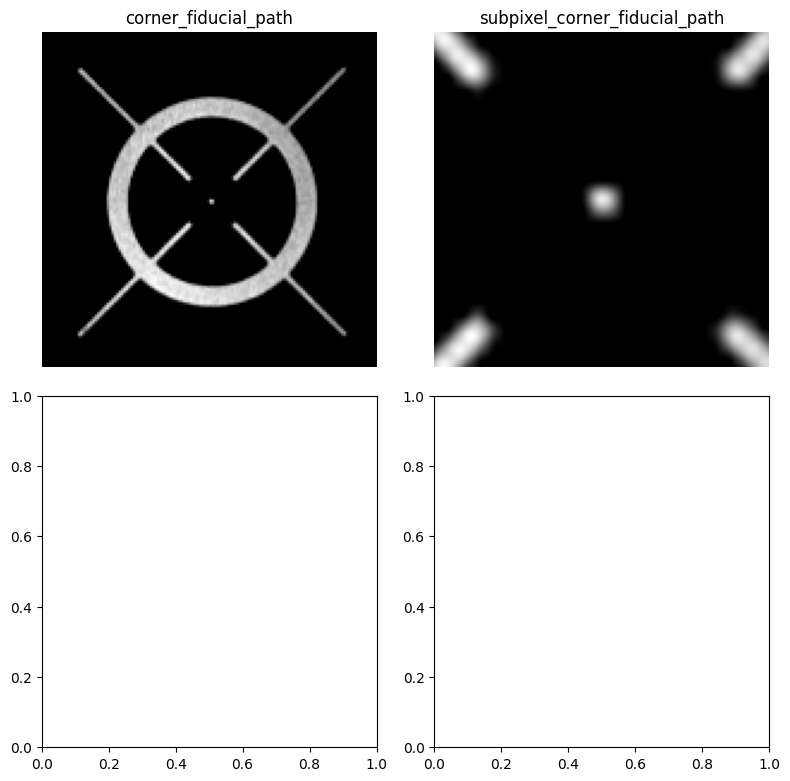

In [20]:
preproc.plot_fiducial_templates()

## Step 2 : fiducials detection

The `AerialPreprocessing.detect_fiducials()` method will detect for all images in the raw images directory, midside fiducials and/or corner fiducials. The method will also save so qc plot to control detections. To work, the method will call for each raw image the function `hipp.aerial.core.detect_fiducials` wich perform the following steps:
- grid the image into a n x n blocks (where n is the parameters `grid_size`).
- if both corner_fiducial and supixel_corner_fiducial exists:
    - perform coarse template matching on the 4 corner blocks
    - refine the position using the supixel_corner_fiducial
- if both midside_fiducial and supixel_midside_fiducial exists:
    - perform coarse template matching on the 4 midside blocks
    - refine the position using the supixel_corner_fiducial
- compute principal point using all detected fiducials

**Note** : 
- this method use multi-threading
- the `grid_size` need to be an **odd number**, and should be chosen such that all fiducials fall within the expected grid layout for accurate detection.

100%|██████████| 125/125 [00:32<00:00,  3.88it/s]


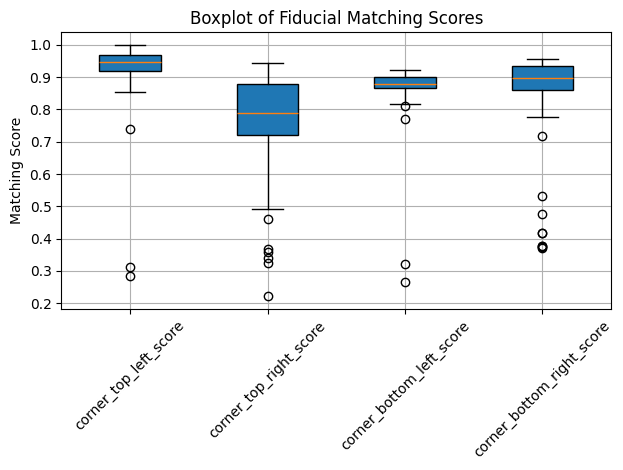

<Figure size 640x480 with 0 Axes>

In [21]:
detected_fiducials_df = preproc.detect_fiducials(grid_size=7, max_workers=MAX_WORKERS)

as we can see on this qc plots the detection seems to be correct cause the distributions of matching score are close from 1. But we observe also some outliers. That can be cause of some miss detection caused by noise on images. You can check what are been detected for the outliers by looking the individuals qc plots.

## Step 3 : Outlier removal

Filters out false positives based on two criteria:

- **Geometric Consistency:** Calculates angles between fiducials, validating those close to 90°, assuming a square fiducial pattern.
- **Matching Score Thresholding:** Compares the score of each match to the median score and keeps only those with a certain threshold 

After filtering:
- The principal point is recalculated using valid diagonal and adjacent fiducials.
- For adjacent fiducials: the midpoint of the segment is computed, and a perpendicular offset is applied based on half the segment length.
- For diagonal fiducials: the midpoint of the segment is used directly.

/home/godinlu/miniconda3/envs/history/lib/python3.11/site-packages/hipp/aerial/aerial_preprocessing.py:252: UserWarning: Principal point could not be computed for 3 detection(s): ['F-9414', 'F-9426', 'F-9458']
  warnings.warn(


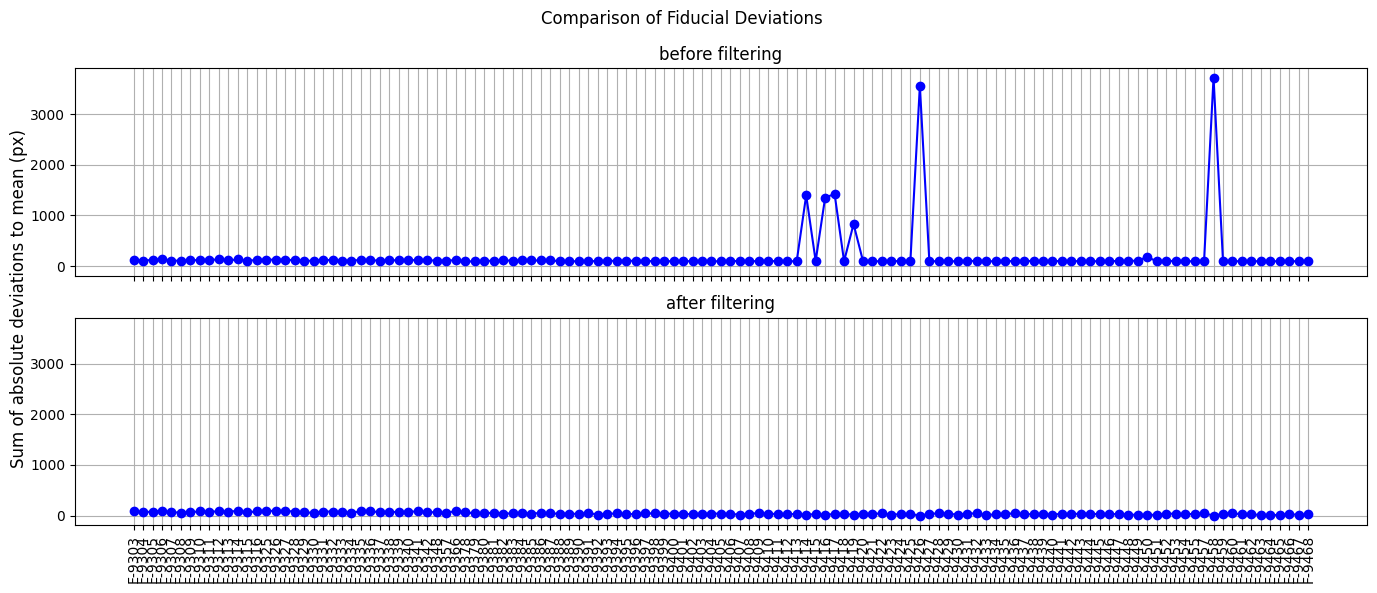

In [22]:
filtered_detected_fiducials_df = preproc.filter_detected_fiducials(detected_fiducials_df)


As we can see on those qc plots, outliers seems to be correctly removed and we now have a decent deviation beetween detected fiducials coordinates.

But the function give us a user warning to tell us that for 3 images the principal point can't be computed.
We can look the detection qc plot to see what append.

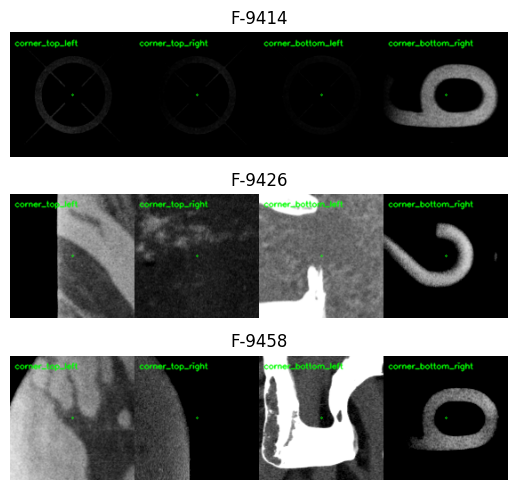

In [23]:
outlier_ids = ['F-9414', 'F-9426', 'F-9458']

outliers_quickviews = [os.path.join(preproc.qc_directory, "fiducial_detections",f"{id}.png" ) for id in outlier_ids]

fig, axes = plt.subplots(3, 1, figsize=(15, 5))

for i, quickview_path in enumerate(outliers_quickviews):
    img = cv2.imread(quickview_path)
    axes[i].imshow(img)
    axes[i].axis('off') 
    axes[i].set_title(outlier_ids[i])
plt.tight_layout()
plt.show()


As we can see, for F-9414, the corner_bottom_left fiducial might need to be removed because it is too eroded.
However, for the other two, no fiducials are detected at all, so we cannot apply a reliable transformation to restore the image accurately.
At minimum, we still want to crop the image, so for the principal points, we will use the median coordinates calculated from the other detected principal points.

In [24]:
pp_keys = ["principal_point_x", "principal_point_y"]

# restitute corner_bottom_left and compute the principal point with it
filtered_detected_fiducials_df.loc["F-9414", ["corner_bottom_left_x", "corner_bottom_left_y"]] = detected_fiducials_df.loc["F-9414", ["corner_bottom_left_x", "corner_bottom_left_y"]]
filtered_detected_fiducials_df.loc["F-9414", pp_keys] = hipp.aerial.fiducials.compute_principal_point(filtered_detected_fiducials_df.loc["F-9414"])

# compute the principal point with the median of other princpipal point
for idx in ['F-9426', 'F-9458']:
    filtered_detected_fiducials_df.loc[idx, pp_keys] = filtered_detected_fiducials_df[pp_keys].median()

filtered_detected_fiducials_df.to_csv(os.path.join(RAW_IMAGES, "detected_fiducial_markers.csv"))

## Step 4 : Prepare calibrated (true) fiducial marker coordinates

- Extract calibrated fiducial marker coordinate information from [calibration report](data/iceland/aerial/1980_08_22/calibration_report.pdf), obtained via entering Camera Number, Lens Number, and Focal Length (printed on image frame) at https://fsapps.nwcg.gov/afm/cam/cam.php
- Extract scanning resolution

In [25]:
true_fiducials_mm = {
    # 1
  'corner_bottom_left_x': -106.0,
  'corner_bottom_left_y': 106.004,

  # 2
  'corner_top_left_x': -106.001,
  'corner_top_left_y': -106.004,

  # 3
  'corner_top_right_x': 106.003,
  'corner_top_right_y': -106.007,

  # 4
  'corner_bottom_right_x': 105.993,
  'corner_bottom_right_y': 105.997
}
# here we inverse y axis cause in the calibration report y axis go down instead of going up
true_fiducials_mm = {key: -value if key.endswith("_y") else value for key, value in true_fiducials_mm.items()}

scanning_resolution_mm = 0.02


## Step 5 : Image restitution

The `AerialPreprocessing.images_restitution` method will preprocess all images in the raw image directory. It also generate a qc plot of the RMSE of the coordinate between true fiducials and detected fiducials before and after the transformation. To work, this method will call for each images the function `hipp.aerial.core.image_restitution` wich will peforms the following steps:
- convert the `true_fiducials_mm` in pixels ( / scanning_resolution_mm)
- translate `true_fiducials_pixels` with the computed principal point
- compute the appropriate geometric transformation to align true fiducials with detected fiducials based on the number of valid detected fiducials:
    - 1 point: Translation
    - 2 points: Similarity transformation
    - 3 or more points: Affine transformation
- transform the image with the computed transformation matrix and crop it with `image_square_dim`.
- Apply CLAHE enhancement

**Note** :
- The transformation matrix returned include the cropping. So if you apply those matrixs on detected fiducials coordinates, you will obtain detected fiducials coordinates of the final image.
- If `true_fiducials_mm` is `None` the first transformation is skipped.
- If `image_square_dim` is `None` the crop is skipped.
- This method use multi-processing to be faster.


Generating quickviews: 100%|██████████| 125/125 [01:39<00:00,  1.25image/s]


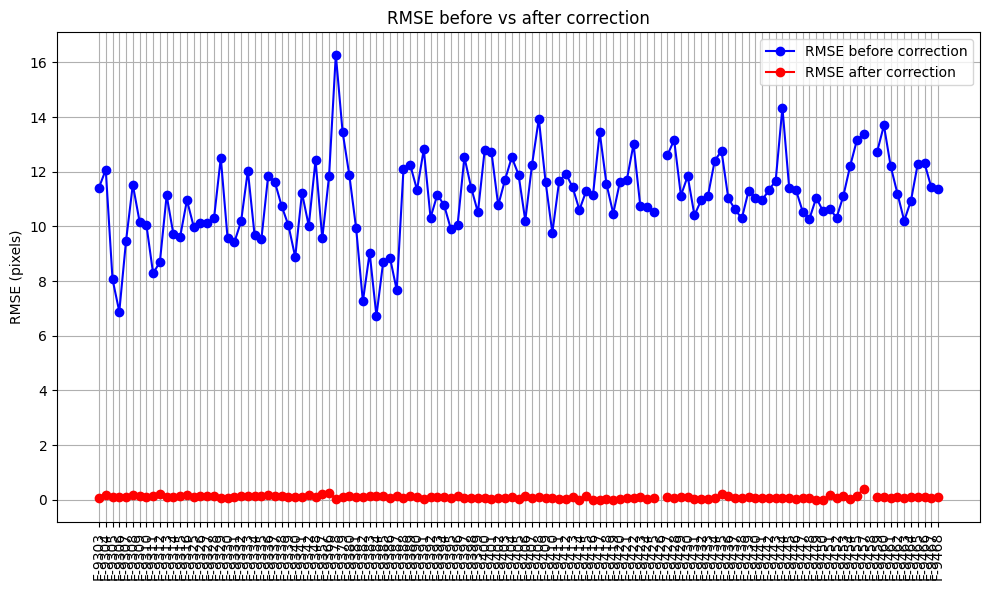

In [26]:
transformation_matrixs = preproc.images_restitution(
    filtered_detected_fiducials_df,
    true_fiducials_mm,
    image_square_dim=10600, # this parameters can be calculated, if i want a 212 mm images then i convert in pixels with 212 / scanning_resolution_mm
    scanning_resolution_mm=scanning_resolution_mm,
    max_workers=MAX_WORKERS,
    dry_run=False # set this option to False to transform images 
)
# generate quickviews of the preprocessed images
hipp.tools.generate_quickviews(PREPROCESSED_IMAGES, QUICKVIEW_FACTOR, max_workers=MAX_WORKERS)

# apply same transformation as images to the fiducials coordinate and save it into a csv
transformed_fiducials = filtered_detected_fiducials_df.apply(lambda row: hipp.aerial.warp_fiducial_coordinates(row, transformation_matrixs[row.name]), axis=1)
transformed_fiducials.to_csv(os.path.join(PREPROCESSED_IMAGES, "detected_fiducial_markers.csv"))